<a href="https://colab.research.google.com/github/atharvakale31/PR_ML/blob/master/Intro_to_Probabilistic_Programming_using_PyMC3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np 
import pylab as pl
import pymc3 as pm
import arviz as az
np.random.seed(123)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rate', 'beta', 'axes', 'step', 'sample', 'size', 'trace']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
#true parameter values
alpha,sigma = 1,1
beta =[1,2.5]

In [3]:
#size of dataset
size=100

In [4]:
#predictor variable
X1 = np.linspace(0,1,size)  # generates equally spaced n(size) numbers from 0 to 1
X2 = np.linspace(0,0.2,size)

µ = α + β1X1 + β2X2 where α is the intercept, and βi is the coefficient for covariate Xi,while σ represents the observation error.

In [5]:
#outcome variable simulation
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

Text(0.5, 0, 'X2')

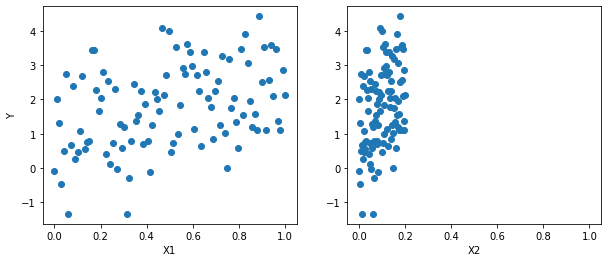

In [6]:
fig, axes = subplots(1, 2, sharex=True, figsize=(10,4)) 
axes[0].scatter(X1, Y) 
axes[1].scatter(X2, Y) 
axes[0].set_ylabel('Y') 
axes[0].set_xlabel('X1') 
axes[1].set_xlabel('X2')

In [7]:
from pymc3 import Model, Normal, HalfNormal

In [8]:
basic_model = Model()

with basic_model:
    #priors for unknown model parameters
    aplha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, shape=2)
    sigma = HalfNormal('sigma', sd=1)
    
    #expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2
    
    #likelihood (sampling distrbution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y )

# Model fitting 
Maximum a posteriori methods


In [9]:
from pymc3 import find_MAP 
map_estimate = find_MAP(model=basic_model) 
print(map_estimate)


{'alpha': array(0.), 'beta': array([1.43620246, 0.28724049]), 'sigma_log__': array(0.11478152), 'sigma': array(1.12162835)}


In [10]:

map_estimate = find_MAP(model=basic_model, method="powell") 
print(map_estimate)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method powell does not use gradient information (jac).
  RuntimeWarning)



{'alpha': array(9.35712959e-09), 'beta': array([1.44685619, 0.25979684]), 'sigma_log__': array(0.11464977), 'sigma': array(1.12148059)}


sampling methods

In [11]:
from pymc3 import NUTS, sample 
with basic_model:
  # obtain starting values via MAP 
  start = find_MAP()
  # instantiate sampler 
  step = NUTS(scaling=start)
  # draw 2000 posterior samples 
  trace = sample(2000, step, start=start)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 8 seconds.


In [12]:
print(trace[1])
print(trace['alpha'])
print(trace['alpha'][-5:])

{'alpha': -9.118882952073132, 'beta': array([1.06975094, 1.18911233]), 'sigma_log__': 0.16251002966182543, 'sigma': 1.1764601178866516}
[  5.88695085   3.7019687    1.47797295 ...   9.02189303 -19.66788953
  -7.70332108]
[  9.51734182 -19.76430163   9.02189303 -19.66788953  -7.70332108]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f466684cd50>,
      dtype=object)

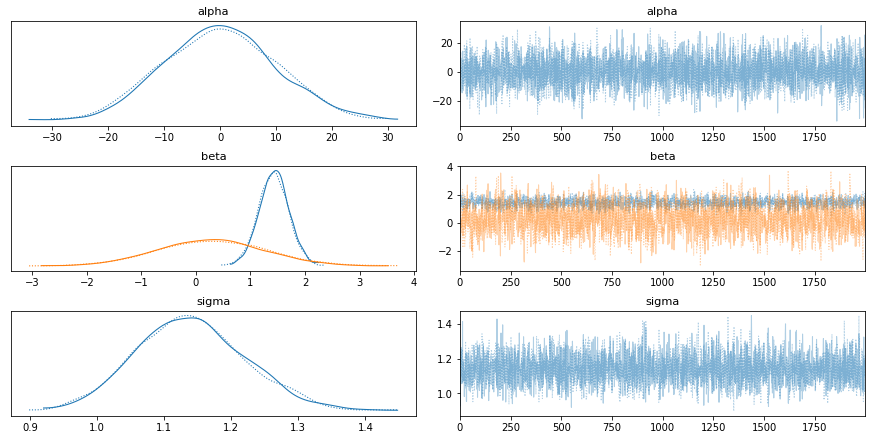

In [13]:
from pymc3 import traceplot
traceplot(trace)

In [14]:
from pymc3 import summary
summary(trace)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.057,10.205,-18.524,19.318,0.137,0.161,5480.0,3160.0,1.0
beta[0],1.428,0.274,0.940,1.978,0.007,0.005,1597.0,2207.0,1.0
beta[1],0.292,0.990,-1.693,2.047,0.025,0.018,1584.0,2239.0,1.0
sigma,1.140,0.082,0.998,1.306,0.001,0.001,4954.0,2772.0,1.0


# Case study 1: Stochastic volatility


In [15]:
import pandas as pd
returns = pd.read_csv(
    pm.get_data("SP500.csv"), parse_dates=True, index_col=0, usecols=["Date", "change"]
)
len( returns)

2906

Text(0, 0.5, 'daily returns in %')

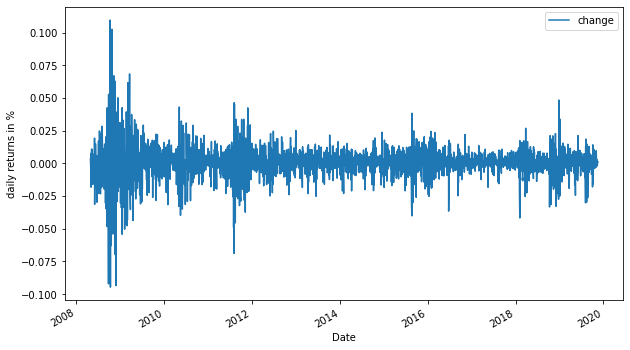

In [16]:
returns.plot(figsize=(10, 6))
plt.ylabel("daily returns in %")

In [17]:
from pymc3 import Exponential, StudentT, Exponential, Deterministic 
from pymc3.distributions.timeseries import GaussianRandomWalk
with Model() as sp500_model:
  nu = Exponential('nu', 1./10, testval=.1) 
  sigma = Exponential('sigma', 1./.02, testval=.1) 
  s = GaussianRandomWalk('s', sigma**-2, shape=400) 
  volatility_process = Deterministic('volatility_process', exp(-2*s)) 
  r = StudentT('r', nu, lam=1/volatility_process, observed=returns)


In [19]:
import scipy 
with sp500_model: 
  start = find_MAP(vars=[s], fmin=scipy.optimize.fmin_l_bfgs_b)
  step = NUTS(scaling=start) 
  trace = sample(50, step, progressbar=False)
# Start next run at the last sampled position. 
  step = NUTS(scaling=trace[-1], gamma=.25) 
  trace = sample(2000, step, start=trace[-1],progressbar=False, njobs=4)

/usr/local/lib/python3.7/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


TypeError: ignored

In [20]:
with sp500_model:
    trace = pm.sample(2000, init="adapt_diag", return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [s, sigma, nu]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Sampling 1 chain for 208 tune and 0 draw iterations (208 + 0 draws total) took 438 seconds.
No posterior samples. Unable to run convergence checks


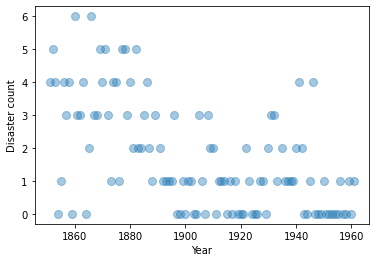

In [18]:
import pandas as pd

# fmt: off
disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)
# fmt: on
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Year");

In [19]:
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform(
        "switchpoint", lower=years.min(), upper=years.max(), testval=1900
    )

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)#switch, a Theano function that works like an if statement. It uses the first argument to switch between the next two arguments.

    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

/usr/local/lib/python3.7/dist-packages/pymc3/model.py:1755: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [20]:
with disaster_model:
    trace = pm.sample(10000, return_inferencedata=False)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 34 seconds.
The number of effective samples is smaller than 10% for some parameters.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f46490a5b90>,
      dtype=object)

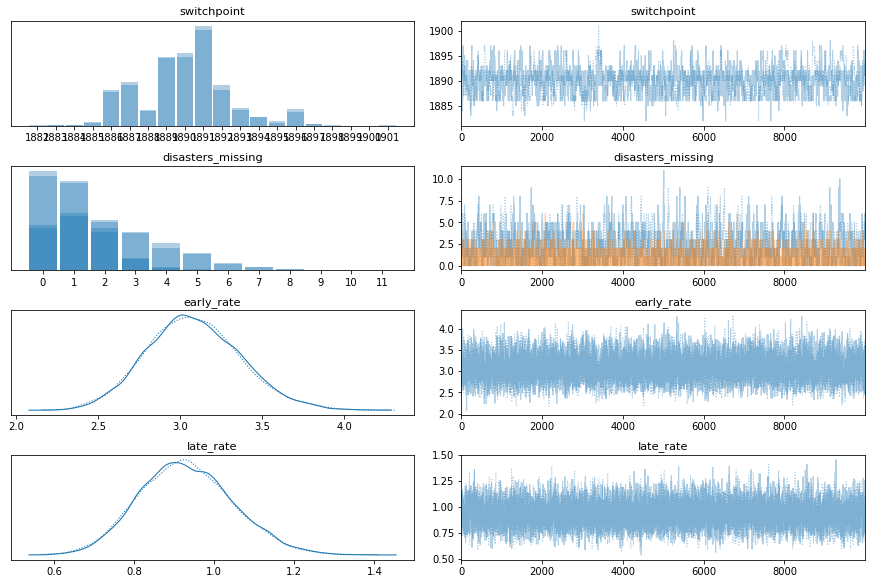

In [21]:
traceplot(trace)

TypeError: ignored

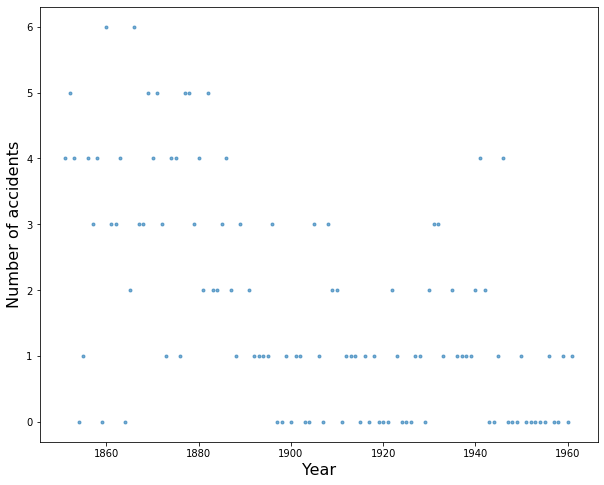

In [25]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, ".", alpha=0.6)
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

plt.vlines(trace["switchpoint"].mean(), disaster_data.min(), disaster_data.max(), color="C1")
average_disasters = np.zeros_like(disaster_data, dtype="float")
for i, year in enumerate(years):
    idx = year < trace["switchpoint"]
    average_disasters[i] = np.mean(np.where(idx, trace["early_rate"], trace["late_rate"]))

sp_hpd = az.hdi(trace["switchpoint"])
plt.fill_betweenx(
    y=[disaster_data.min(), disaster_data.max()],
    x1=sp_hpd[0],
    x2=sp_hpd[1],
    alpha=0.5,
    color="C1",
)
plt.plot(years, average_disasters, "k--", lw=2);

In [33]:
with disaster_model:
   print(trace[0])

TypeError: ignored